[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/vector_quantization/VQ_grayscale_image.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/vector_quantization/VQ_grayscale_image.ipynb)


# Vector Quantization (in the 2D domain) of a color (RGB) image

See [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

In [1]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [2]:
%%bash
if [ -d "$HOME/repos/scalar_quantization" ]; then
    cd $HOME/repos/scalar_quantization
    echo "$HOME/repos/scalar_quantization ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/scalar_quantization.git
fi

/home/vruiz/repos/scalar_quantization ... 
Ya está actualizado.


In [3]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

/home/vruiz/repos/image_IO ... 
Ya está actualizado.


In [4]:
%%bash
if [ -d "$HOME/repos/MRVC" ]; then
    cd $HOME/repos/MRVC
    echo "$HOME/repos/MRVC ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/Sistemas-Multimedia/MRVC.git
fi

/home/vruiz/repos/MRVC ... 
Ya está actualizado.


In [5]:
!ln -sf ~/repos/information_theory/information.py .
!ln -sf ~/repos/information_theory/distortion.py .
!ln -sf ~/repos/image_IO/image_3.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [6]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
%matplotlib inline

try:
    import scipy
except:
    !pip install scipy

import numpy as np

try:
    import cv2
except:
    !pip install opencv-python
    !pip install opencv-python-headless # Binder compatibility

try:
    from sklearn import cluster
except:
    !pip install sklearn
    from sklearn import cluster

import os
import pylab

try:
    import colored
except:
    !pip install colored

import image_1 as gray_image

try:
    import skimage
except:
    !pip install scikit-image
    import skimage
    
import distortion
import math
import image_3 as RGB_image

!ln -sf ~/repos/DCT/color_DCT.py .
import color_DCT as YUV
#!ln -sf ~/repos/YCrCb/YCrCb.py .
#import YCrCb as YUV
#!ln -sf ~/repos/YCoCg/YCoCg.py .
#import YCoCg as YUV
#!ln -sf ~/repos/RGB/RGB.py
#import RGB as YUV

## Configuration

In [7]:
home = os.environ["HOME"]
fn = home + "/repos/MRVC/images/lena_color/"
block_width = 16
block_height = 16
N_components = 3
n_clusters = 256  # Number of bins
N_tries = 3  # Number of times K-means is run
#range_of_N_bins = range(2, 256, 1)
range_of_N_bins = [1<<i for i in range(1, 10)]

#RGB_image.write = RGB_image.debug_write # Faster, but lower compression
#RGB_image.write = RGB_image.write # The fastest, but returns only an estimation of the length

## Read the image and show it

(512, 512, 3)


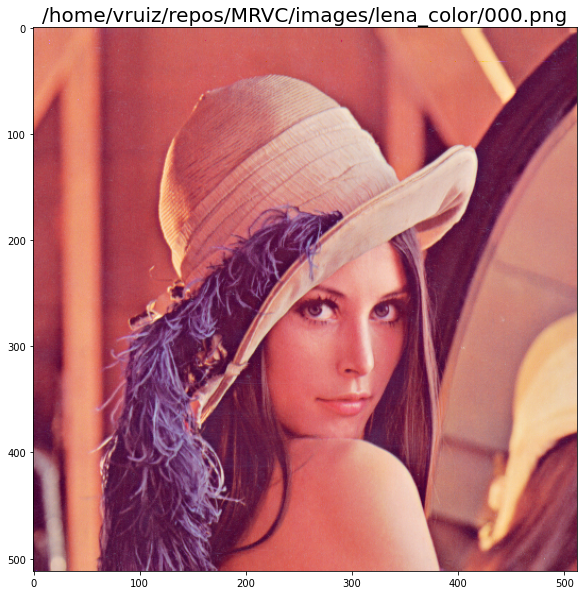

In [8]:
img = RGB_image.read(fn)
RGB_image.show(img, fn + "000.png")
print(img.shape)

## Example

In [9]:
block_width*block_height*N_components

768

In [10]:
block_length = block_width*block_height*N_components
np.random.seed(seed=1)  # makes the random numbers predictable
k_means = cluster.KMeans(init="k-means++", n_clusters=n_clusters, n_init=N_tries)
blocks = []
for i in range(0, img.shape[0], block_width):
    for j in range(0, img.shape[1], block_height):
        blocks.append(np.reshape(img[i:i + block_width, j:j + block_height], block_length))
blocks = np.asarray(blocks).astype(float)
k_means.fit(blocks)
centroids = k_means.cluster_centers_.squeeze().astype(np.uint8)  # the code-book
labels = k_means.labels_  # Labels of the centroids

labels = labels.reshape(img.shape[0]//block_height, img.shape[1]//block_width)
img_dequantized = np.empty_like(img)
for i in range(0, img.shape[0], block_width):
    for j in range(0, img.shape[1], block_height):
        img_dequantized[i:i + block_width, j:j + block_height] = centroids[labels[i//block_width,j//block_height]].reshape(block_height, block_width, N_components)

centroids =
 [[178  70  81 ... 183  73  82]
 [216 172 161 ... 221 153 148]
 [103  27  65 ... 113  34  69]
 ...
 [179  60  73 ... 169  82 114]
 [ 96  36  72 ...  87  24  61]
 [155  80  95 ...  80  18  61]]
256 centroids (8 bits/block)
32x32 blocks (vectors) in the image
total number of output bytes = 1024


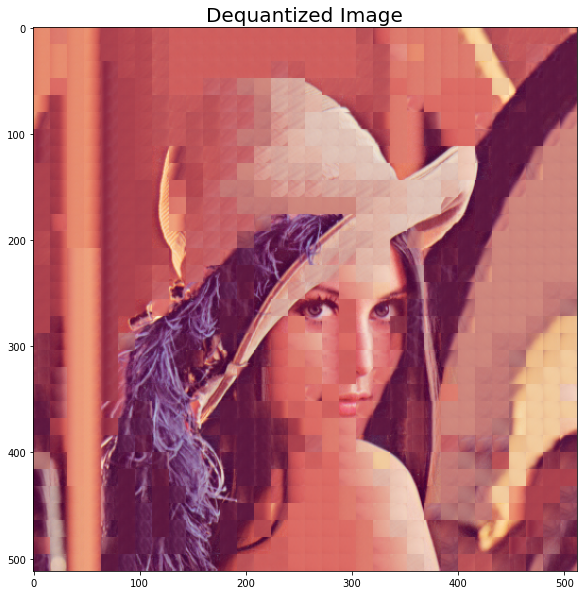

In [11]:
RGB_image.show(img_dequantized, "Dequantized Image")
assert len(centroids) == n_clusters
print("centroids =\n", centroids)
bits_per_block = int(math.log(n_clusters)/math.log(2))
print(f"{len(centroids)} centroids ({bits_per_block} bits/block)")
blocks_in_y = img.shape[0]//block_height
blocks_in_x = img.shape[1]//block_width
print(f"{blocks_in_y}x{blocks_in_x} blocks (vectors) in the image")
number_of_blocks = blocks_in_y*blocks_in_x
total_number_of_bits = number_of_blocks*bits_per_block
print(f"total number of output bytes = {total_number_of_bits//8}")

## RD performance

In [12]:
def RD_curve(img, range_of_N_bins):
    blocks = []
    for i in range(0, img.shape[0], block_width):
        for j in range(0, img.shape[1], block_height):
            blocks.append(np.reshape(img[i:i + block_width, j:j + block_height], block_length))
    blocks = np.asarray(blocks).astype(float)
    points = []
    for n in range_of_N_bins:
        k_means = cluster.KMeans(init="k-means++", n_clusters=n, n_init=N_tries)
        k_means.fit(blocks)
        centroids = k_means.cluster_centers_.squeeze().astype(np.uint8)
        k = k_means.labels_.astype(np.uint16)  # bit-depth depends on number of bins! 
        k = k.reshape(img.shape[0]//block_height, img.shape[1]//block_width)
        y = np.empty_like(img)
        for i in range(0, img.shape[0], block_width):
            for j in range(0, img.shape[1], block_height):
                y[i:i + block_width, j:j + block_height] = centroids[k[i//block_width,j//block_height]].reshape(block_height, block_width, N_components)
        print("Quantization indexes: ", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/img.size
        _distortion = distortion.RMSE(img, y)
        if not n%10:
            plt.title(f"{n}")
            plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
            plt.show()
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points
RD_points = RD_curve(img, range_of_N_bins)

Quantization indexes:  [0 1]
n=  2, rate=0.0024007161458333335 bits/pixel, distortion=  32.6
Quantization indexes:  [0 1 2 3]
n=  4, rate=0.0037333170572916665 bits/pixel, distortion=  26.3
Quantization indexes:  [0 1 2 3 4 5 6 7]
n=  8, rate=0.004669189453125 bits/pixel, distortion=  22.9
Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
n= 16, rate=0.005706787109375 bits/pixel, distortion=  20.7
Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
n= 32, rate=0.006846110026041667 bits/pixel, distortion=  18.5
Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
n= 64, rate=0.008219401041666666 bits/pixel, distortion=  16.4
Quantization indexes:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20 

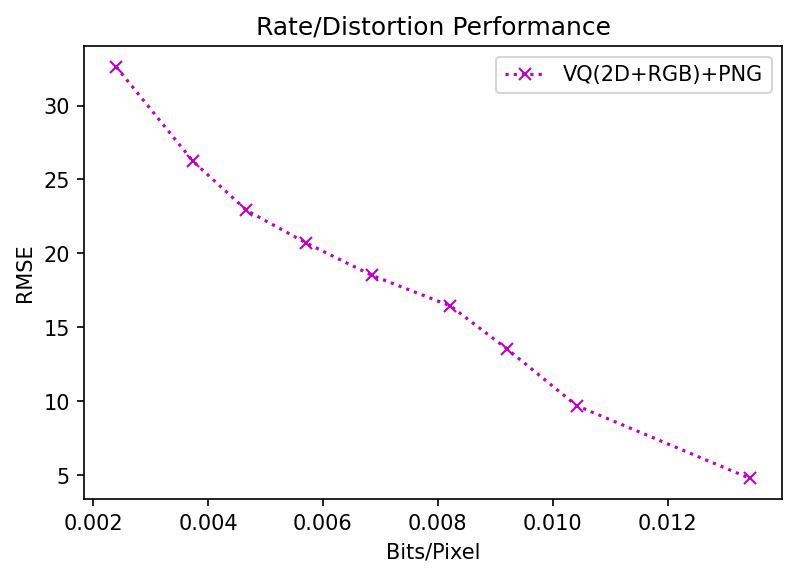

In [13]:
pylab.figure(dpi=150)
#pylab.scatter(*zip(*RD_points), label=f"VQ+PNG", s=1, marker='.')
pylab.plot(*zip(*RD_points), c='m', marker='x', label=f"VQ(2D+RGB)+PNG", linestyle="dotted")
pylab.title(f"Rate/Distortion Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

In [14]:
with open(f"VQ_2D_RGB_RD_points.txt", 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

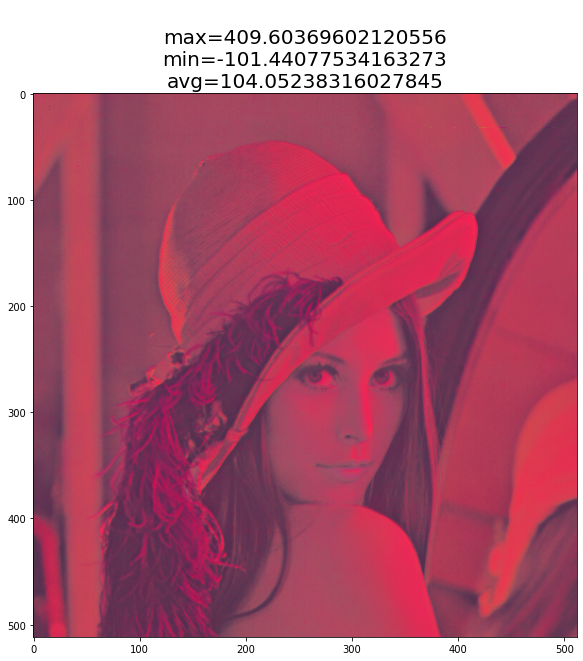

In [15]:
img = RGB_image.read(fn)
if YUV.name == "YCoCg":
    img = img.astype(np.int16)
if YUV.name =="color-DCT":
    img = img.astype(float)
img = YUV.from_RGB(img)
RGB_image.show_normalized(img)

In [16]:
block_length = block_width*block_height*N_components
np.random.seed(seed=1)  # makes the random numbers predictable
k_means = cluster.KMeans(init="k-means++", n_clusters=n_clusters, n_init=N_tries)
blocks = []
for i in range(0, img.shape[0], block_width):
    for j in range(0, img.shape[1], block_height):
        blocks.append(np.reshape(img[i:i + block_width, j:j + block_height], block_length))
blocks = np.asarray(blocks).astype(float)
k_means.fit(blocks)
centroids = k_means.cluster_centers_.squeeze().astype(np.uint16)  # the code-book
labels = k_means.labels_  # Labels of the centroids

In [17]:
labels = labels.reshape(img.shape[0]//block_height, img.shape[1]//block_width)
img_dequantized = np.empty_like(img)
for i in range(0, img.shape[0], block_width):
    for j in range(0, img.shape[1], block_height):
        img_dequantized[i:i + block_width, j:j + block_height] = centroids[labels[i//block_width,j//block_height]].reshape(block_height, block_width, N_components)

In [18]:
#img_dequantized = img.copy()

centroids =
 [[  185    36    86 ...   192    38    87]
 [  312 65530    68 ...   296     6    79]
 [  105     6    66 ...   118     8    68]
 ...
 [  175    43    90 ...   202     4    86]
 [  110 65533    59 ...    92     0    58]
 [  184    11    71 ...    83 65533    58]]
256 centroids (8 bits/block)
32x32 blocks (vectors) in the image
total number of output bytes = 1024


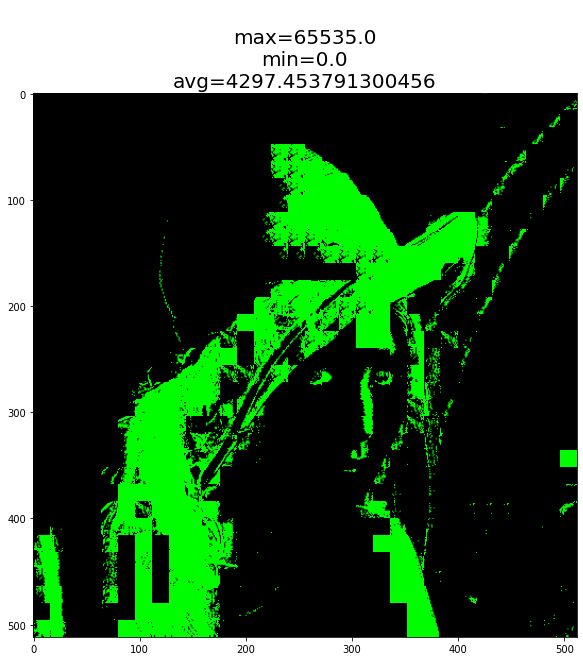

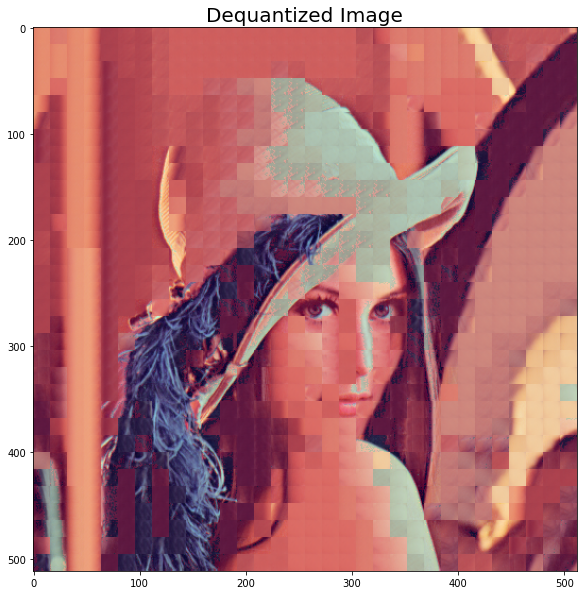

In [19]:
RGB_image.show_normalized(img_dequantized)
img_dequantized = YUV.to_RGB(img_dequantized).astype(np.uint8)
RGB_image.show(img_dequantized, "Dequantized Image")
assert len(centroids) == n_clusters
print("centroids =\n", centroids)
bits_per_block = int(math.log(n_clusters)/math.log(2))
print(f"{len(centroids)} centroids ({bits_per_block} bits/block)")
blocks_in_y = img.shape[0]//block_height
blocks_in_x = img.shape[1]//block_width
print(f"{blocks_in_y}x{blocks_in_x} blocks (vectors) in the image")
number_of_blocks = blocks_in_y*blocks_in_x
total_number_of_bits = number_of_blocks*bits_per_block
print(f"total number of output bytes = {total_number_of_bits//8}")

Quantization indexes:  [0 1]
n=  2, rate=0.0024007161458333335 bits/pixel, distortion=  32.6
Quantization indexes:  [0 1 2 3]
n=  4, rate=0.0037333170572916665 bits/pixel, distortion=  27.4
Quantization indexes:  [0 1 2 3 4 5 6 7]
n=  8, rate=0.004669189453125 bits/pixel, distortion=  25.4
Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
n= 16, rate=0.005706787109375 bits/pixel, distortion=  23.7
Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
n= 32, rate=0.006846110026041667 bits/pixel, distortion=  22.0
Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
n= 64, rate=0.008219401041666666 bits/pixel, distortion=  20.4
Quantization indexes:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20 

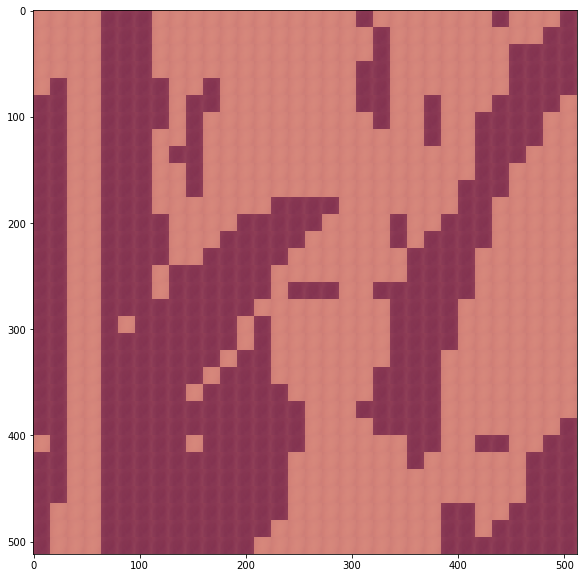

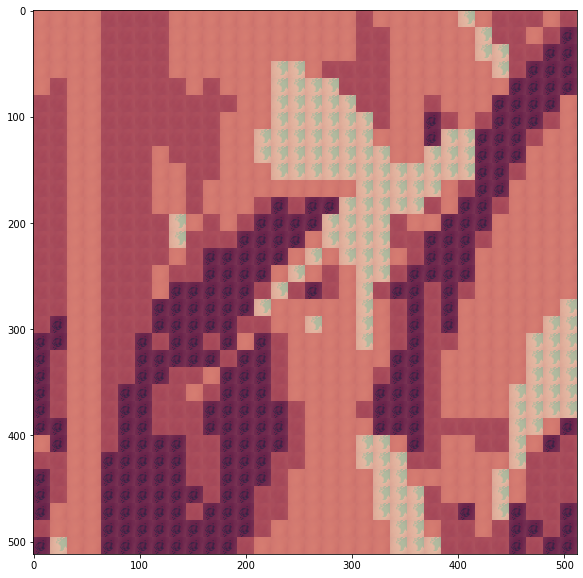

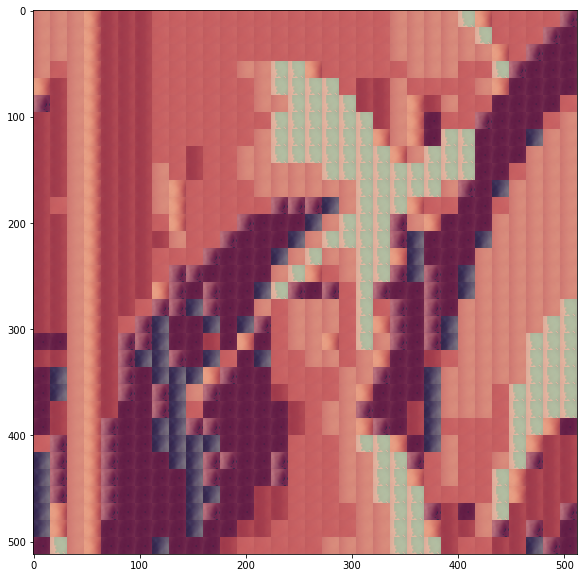

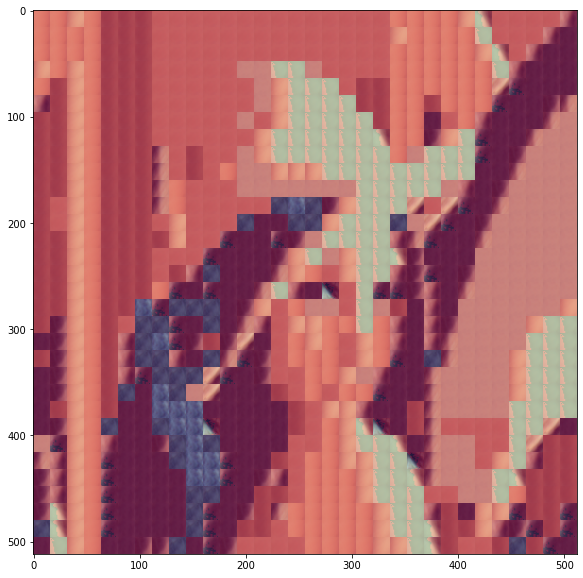

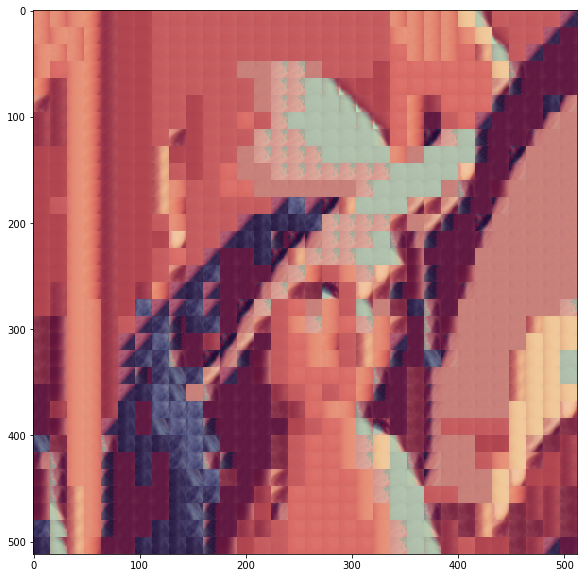

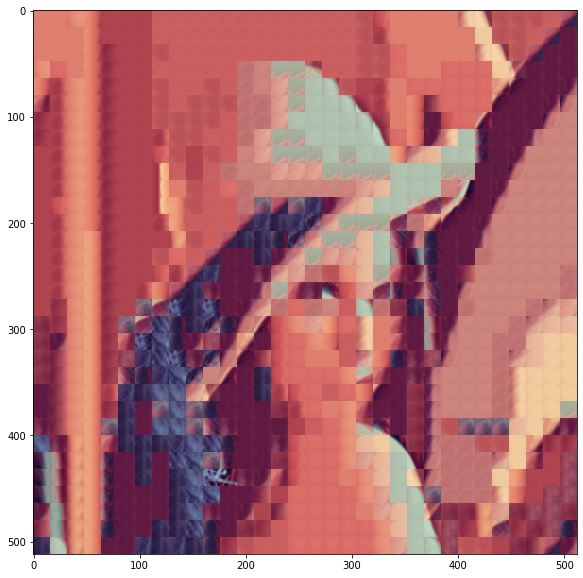

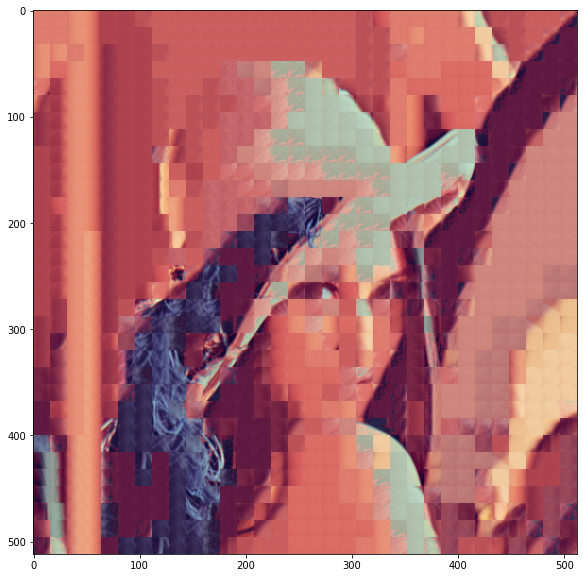

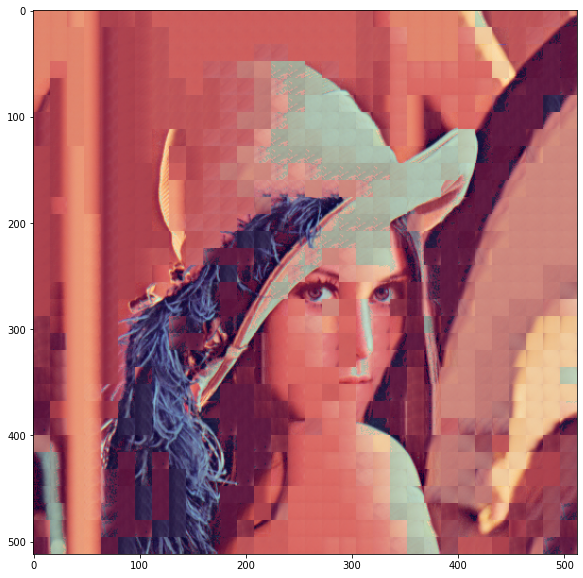

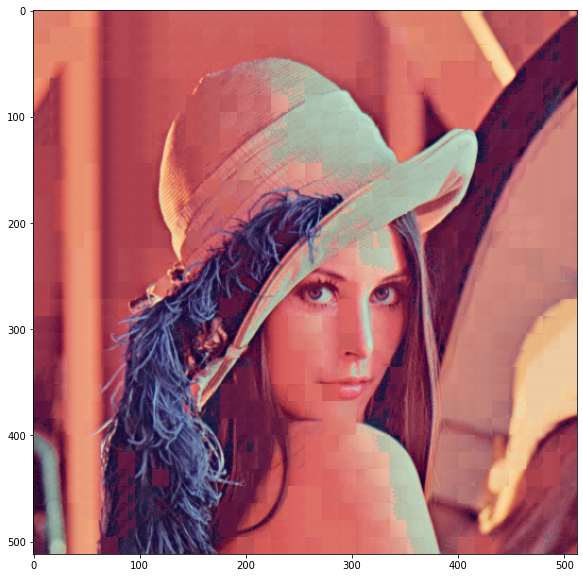

In [20]:
def RD_curve(img, range_of_N_bins):
    if YUV.name == "YCoCg":
        img = img.astype(np.int16)
    YUV_img = YUV.from_RGB(img)
    blocks = []
    for i in range(0, YUV_img.shape[0], block_width):
        for j in range(0, YUV_img.shape[1], block_height):
            blocks.append(np.reshape(YUV_img[i:i + block_width, j:j + block_height], block_length))
    blocks = np.asarray(blocks).astype(float)
    points = []
    for n in range_of_N_bins:
        k_means = cluster.KMeans(init="k-means++", n_clusters=n, n_init=N_tries)
        k_means.fit(blocks)
        centroids = k_means.cluster_centers_.squeeze().astype(np.uint16)
        k = k_means.labels_.astype(np.uint16)  # bit-depth depends on number of bins! 
        k = k.reshape(YUV_img.shape[0]//block_height, YUV_img.shape[1]//block_width)
        YUV_y = np.empty_like(YUV_img)
        for i in range(0, YUV_img.shape[0], block_width):
            for j in range(0, YUV_img.shape[1], block_height):
                YUV_y[i:i + block_width, j:j + block_height] = centroids[k[i//block_width,j//block_height]].reshape(block_height, block_width, N_components)
        print("Quantization indexes: ", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/img.size
        y = YUV.to_RGB(YUV_y).astype(np.uint8)
        _distortion = distortion.RMSE(img, y)
        RGB_image.show(y)
        if not n%10:
            plt.title(f"{n}")
            plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
            plt.show()
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

img = RGB_image.read(fn)
RD_points_YUV = RD_curve(img, range_of_N_bins)

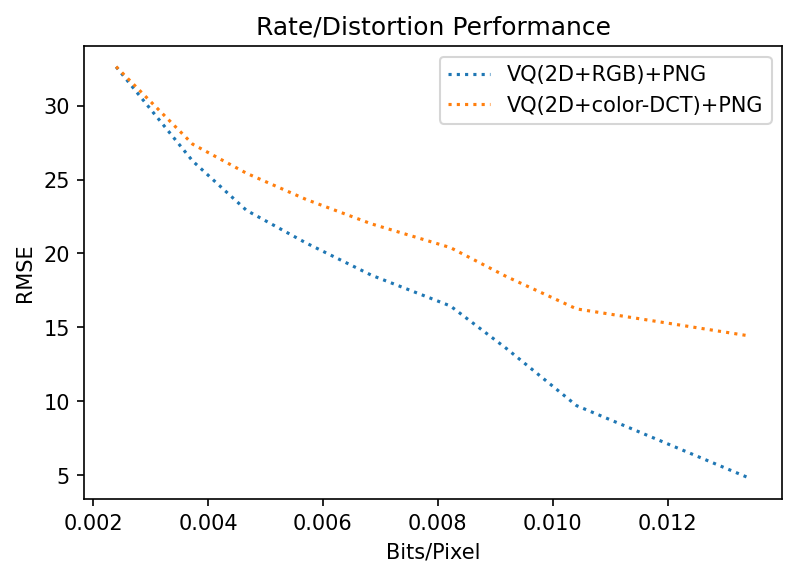

In [21]:
pylab.figure(dpi=150)
#pylab.scatter(*zip(*RD_points), label=f"VQ+PNG", s=1, marker='.')
pylab.plot(*zip(*RD_points), label=f"VQ(2D+RGB)+PNG", linestyle="dotted")
pylab.plot(*zip(*RD_points_YUV), label=f"VQ(2D+{YUV.name})+PNG", linestyle="dotted")
pylab.title(f"Rate/Distortion Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
import time
while True:
    time.sleep(1)